In [7]:
import requests
from bs4 import BeautifulSoup
import re
import requests
import numpy as np
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer 

In [8]:
def getText(URL):
    r = requests.get(URL)
    soup = BeautifulSoup(r.text, 'html.parser')
    all_text = soup.get_text().lstrip('Learning Objectives').rstrip('PreviousNext')
    selection_text = re.sub('PreviousNext.+', '', all_text, flags=re.DOTALL)
    selection_text = re.sub('.+Learning Objectives', '', selection_text, flags=re.DOTALL)
    return(selection_text)

def getKeywords(URL):
    r = requests.get(URL)
    soup = BeautifulSoup(r.text, 'html.parser')
    keywords = soup.find_all('dt')
    return [keyword.text for keyword in keywords]

def twoDig(number):
    if len(str(number)) == 1:
        return '0'+str(number)
    else:
        return str(number)
    
def compareToList(word_list, reference_list):
    matches = 0
    for word in reference_list:
        if word in word_list:
            matches += 1
    return matches/len(reference_list)

def compareToListPrecision(word_list, reference_list):
    matches = 0
    for word in reference_list:
        if word in word_list:
            matches += 1
    if len(word_list) == 0:
        return np.inf
    else:
        return matches/len(word_list)

def keyness(freq_dict1,freq_dict2,effect = "log-ratio"): #this assumes that raw frequencies were used. effect options = "log-ratio", "%diff", "odds-ratio"
    keyness_dict = {}
    ref_dict = {}
    
    size1 = sum(freq_dict1.values())
    size2 = sum(freq_dict2.values())

    def log_ratio(freq1,size1,freq2,size2): 
        freq1_norm = freq1/size1 * 1000000
        freq2_norm = freq2/size2 * 1000000
        index = math.log2(freq1_norm/freq2_norm)
        return(index)

    def perc_diff(freq1,size1,freq2,size2):
        freq1_norm = freq1/size1 * 1000000
        freq2_norm = freq2/size2 * 1000000
        index = ((freq1_norm-freq2_norm)  * 100)/freq2_norm
        return(index)
    
    def odds_ratio(freq1,size1,freq2,size2):
        if size1 - freq1 == 0: #this will be a very rare case, but would kill program
            size1 += 1
        if size2 - freq2 == 0: #this will be a very rare case, but would kill program
            size2 += 1
        index = (freq1/(size1-freq1))/(freq2/(size2-freq2))
        return(index)


    #create combined word list (we actually use a dictionary for speed)
    for x in freq_dict1:
        if x not in ref_dict:
            ref_dict[x] = 0 #the zero isn't used for anything
    for x in freq_dict2:
        if x not in ref_dict:
            ref_dict[x] = 0 #the zero isn't used for anything
    
    #if our item doesn't occur in one of our reference corpora, we need to make an adjustment
    #here, we change the frequency to a very small number (.00000001) instead of zero
    #this is because zeros will cause problems in our calculation of keyness
    for item in ref_dict:
        if item not in freq_dict1 or freq_dict1[item] == 0:
            freq_dict1[item] = .00000001 #tiny number
        if item not in freq_dict2 or freq_dict2[item] == 0:
            freq_dict2[item] = .00000001 #tiny number

        if effect == 'log-ratio':
            keyness_dict[item] = log_ratio(freq_dict1[item],size1,freq_dict2[item],size2)

        elif effect == "%diff":
            keyness_dict[item] = perc_diff(freq_dict1[item],size1,freq_dict2[item],size2)

        elif effect == "odds-ratio":
            keyness_dict[item] = odds_ratio(freq_dict1[item],size1,freq_dict2[item],size2)

    return(keyness_dict)

def keywordCombiner(chapter, generator):
    chapter_df = sections_df[sections_df['chapter'] == chapter]
    keyword_list = []
    for i in chapter_df[generator]:
        keyword_list += list(i)
    return keyword_list

### Get URLS for all of the chapters and keyword pages

In [9]:
chapter_urls = {'01-1': 'https://openstax.org/books/principles-macroeconomics-2e/pages/1-1-what-is-economics-and-why-is-it-important',
                '01-2': 'https://openstax.org/books/principles-macroeconomics-2e/pages/1-2-microeconomics-and-macroeconomics',
                '01-3': 'https://openstax.org/books/principles-macroeconomics-2e/pages/1-3-how-economists-use-theories-and-models-to-understand-economic-issues',
                '01-4': 'https://openstax.org/books/principles-macroeconomics-2e/pages/1-4-how-to-organize-economies-an-overview-of-economic-systems',
                '02-1': 'https://openstax.org/books/principles-macroeconomics-2e/pages/2-1-how-individuals-make-choices-based-on-their-budget-constraint',
                '02-2': 'https://openstax.org/books/principles-macroeconomics-2e/pages/2-2-the-production-possibilities-frontier-and-social-choices',
                '02-3': 'https://openstax.org/books/principles-macroeconomics-2e/pages/2-3-confronting-objections-to-the-economic-approach',
                '03-1': 'https://openstax.org/books/principles-macroeconomics-2e/pages/3-1-demand-supply-and-equilibrium-in-markets-for-goods-and-services',
                '03-2': 'https://openstax.org/books/principles-macroeconomics-2e/pages/3-2-shifts-in-demand-and-supply-for-goods-and-services',
                '03-3': 'https://openstax.org/books/principles-macroeconomics-2e/pages/3-3-changes-in-equilibrium-price-and-quantity-the-four-step-process',
                '03-4': 'https://openstax.org/books/principles-macroeconomics-2e/pages/3-4-price-ceilings-and-price-floors',
                '03-5': 'https://openstax.org/books/principles-macroeconomics-2e/pages/3-5-demand-supply-and-efficiency',
                '04-1': 'https://openstax.org/books/principles-macroeconomics-2e/pages/4-1-demand-and-supply-at-work-in-labor-markets',
                '04-2': 'https://openstax.org/books/principles-macroeconomics-2e/pages/4-2-demand-and-supply-in-financial-markets',
                '04-3': 'https://openstax.org/books/principles-macroeconomics-2e/pages/4-3-the-market-system-as-an-efficient-mechanism-for-information',
                '05-1': 'https://openstax.org/books/principles-macroeconomics-2e/pages/5-1-price-elasticity-of-demand-and-price-elasticity-of-supply',
                '05-2': 'https://openstax.org/books/principles-macroeconomics-2e/pages/5-2-polar-cases-of-elasticity-and-constant-elasticity',
                '05-3': 'https://openstax.org/books/principles-macroeconomics-2e/pages/5-3-elasticity-and-pricing',
                '05-4': 'https://openstax.org/books/principles-macroeconomics-2e/pages/5-4-elasticity-in-areas-other-than-price',
                '06-1': 'https://openstax.org/books/principles-macroeconomics-2e/pages/6-1-measuring-the-size-of-the-economy-gross-domestic-product',
                '06-2': 'https://openstax.org/books/principles-macroeconomics-2e/pages/6-2-adjusting-nominal-values-to-real-values',
                '06-3': 'https://openstax.org/books/principles-macroeconomics-2e/pages/6-3-tracking-real-gdp-over-time',
                '06-4': 'https://openstax.org/books/principles-macroeconomics-2e/pages/6-4-comparing-gdp-among-countries',
                '06-5': 'https://openstax.org/books/principles-macroeconomics-2e/pages/6-5-how-well-gdp-measures-the-well-being-of-society',
                '07-1': 'https://openstax.org/books/principles-macroeconomics-2e/pages/7-1-the-relatively-recent-arrival-of-economic-growth',
                '07-2': 'https://openstax.org/books/principles-macroeconomics-2e/pages/7-2-labor-productivity-and-economic-growth',
                '07-3': 'https://openstax.org/books/principles-macroeconomics-2e/pages/7-3-components-of-economic-growth',
                '07-4': 'https://openstax.org/books/principles-macroeconomics-2e/pages/7-4-economic-convergence',
                '08-1': 'https://openstax.org/books/principles-macroeconomics-2e/pages/8-1-how-economists-define-and-compute-unemployment-rate',
                '08-2': 'https://openstax.org/books/principles-macroeconomics-2e/pages/8-2-patterns-of-unemployment',
                '08-3': 'https://openstax.org/books/principles-macroeconomics-2e/pages/8-3-what-causes-changes-in-unemployment-over-the-short-run',
                '08-4': 'https://openstax.org/books/principles-macroeconomics-2e/pages/8-4-what-causes-changes-in-unemployment-over-the-long-run',
                '09-1': 'https://openstax.org/books/principles-macroeconomics-2e/pages/9-1-tracking-inflation',
                '09-2': 'https://openstax.org/books/principles-macroeconomics-2e/pages/9-2-how-to-measure-changes-in-the-cost-of-living',
                '09-3': 'https://openstax.org/books/principles-macroeconomics-2e/pages/9-3-how-the-u-s-and-other-countries-experience-inflation',
                '09-4': 'https://openstax.org/books/principles-macroeconomics-2e/pages/9-4-the-confusion-over-inflation',
                '09-5': 'https://openstax.org/books/principles-macroeconomics-2e/pages/9-5-indexing-and-its-limitations',
                '10-1': 'https://openstax.org/books/principles-macroeconomics-2e/pages/10-1-measuring-trade-balances',
                '10-2': 'https://openstax.org/books/principles-macroeconomics-2e/pages/10-2-trade-balances-in-historical-and-international-context',
                '10-3': 'https://openstax.org/books/principles-macroeconomics-2e/pages/10-3-trade-balances-and-flows-of-financial-capital',
                '10-4': 'https://openstax.org/books/principles-macroeconomics-2e/pages/10-4-the-national-saving-and-investment-identity',
                '10-5': 'https://openstax.org/books/principles-macroeconomics-2e/pages/10-5-the-pros-and-cons-of-trade-deficits-and-surpluses',
                '10-6': 'https://openstax.org/books/principles-macroeconomics-2e/pages/10-6-the-difference-between-level-of-trade-and-the-trade-balance',
                '11-1': 'https://openstax.org/books/principles-macroeconomics-2e/pages/11-1-macroeconomic-perspectives-on-demand-and-supply',
                '11-2': 'https://openstax.org/books/principles-macroeconomics-2e/pages/11-2-building-a-model-of-aggregate-demand-and-aggregate-supply',
                '11-3': 'https://openstax.org/books/principles-macroeconomics-2e/pages/11-3-shifts-in-aggregate-supply',
                '11-4': 'https://openstax.org/books/principles-macroeconomics-2e/pages/11-4-shifts-in-aggregate-demand',
                '11-5': 'https://openstax.org/books/principles-macroeconomics-2e/pages/11-5-how-the-ad-as-model-incorporates-growth-unemployment-and-inflation',
                '11-6': 'https://openstax.org/books/principles-macroeconomics-2e/pages/11-6-keynes-law-and-says-law-in-the-ad-as-model',
                '12-1': 'https://openstax.org/books/principles-macroeconomics-2e/pages/12-1-aggregate-demand-in-keynesian-analysis',
                '12-2': 'https://openstax.org/books/principles-macroeconomics-2e/pages/12-2-the-building-blocks-of-keynesian-analysis',
                '12-3': 'https://openstax.org/books/principles-macroeconomics-2e/pages/12-3-the-phillips-curve',
                '12-4': 'https://openstax.org/books/principles-macroeconomics-2e/pages/12-4-the-keynesian-perspective-on-market-forces',
                '13-1': 'https://openstax.org/books/principles-macroeconomics-2e/pages/13-1-the-building-blocks-of-neoclassical-analysis',
                '13-2': 'https://openstax.org/books/principles-macroeconomics-2e/pages/13-2-the-policy-implications-of-the-neoclassical-perspective',
                '13-3': 'https://openstax.org/books/principles-macroeconomics-2e/pages/13-3-balancing-keynesian-and-neoclassical-models',
                '14-1': 'https://openstax.org/books/principles-macroeconomics-2e/pages/14-1-defining-money-by-its-functions',
                '14-2': 'https://openstax.org/books/principles-macroeconomics-2e/pages/14-2-measuring-money-currency-m1-and-m2',
                '14-3': 'https://openstax.org/books/principles-macroeconomics-2e/pages/14-3-the-role-of-banks',
                '14-4': 'https://openstax.org/books/principles-macroeconomics-2e/pages/14-4-how-banks-create-money',
                '15-1': 'https://openstax.org/books/principles-macroeconomics-2e/pages/15-1-the-federal-reserve-banking-system-and-central-banks',
                '15-2': 'https://openstax.org/books/principles-macroeconomics-2e/pages/15-2-bank-regulation',
                '15-3': 'https://openstax.org/books/principles-macroeconomics-2e/pages/15-3-how-a-central-bank-executes-monetary-policy',
                '15-4': 'https://openstax.org/books/principles-macroeconomics-2e/pages/15-4-monetary-policy-and-economic-outcomes',
                '15-5': 'https://openstax.org/books/principles-macroeconomics-2e/pages/15-5-pitfalls-for-monetary-policy',
                '16-1': 'https://openstax.org/books/principles-macroeconomics-2e/pages/16-1-how-the-foreign-exchange-market-works',
                '16-2': 'https://openstax.org/books/principles-macroeconomics-2e/pages/16-2-demand-and-supply-shifts-in-foreign-exchange-markets',
                '16-3': 'https://openstax.org/books/principles-macroeconomics-2e/pages/16-3-macroeconomic-effects-of-exchange-rates',
                '16-4': 'https://openstax.org/books/principles-macroeconomics-2e/pages/16-4-exchange-rate-policies',
                '17-1': 'https://openstax.org/books/principles-macroeconomics-2e/pages/17-1-government-spending',
                '17-2': 'https://openstax.org/books/principles-macroeconomics-2e/pages/17-2-taxation',
                '17-3': 'https://openstax.org/books/principles-macroeconomics-2e/pages/17-3-federal-deficits-and-the-national-debt',
                '17-4': 'https://openstax.org/books/principles-macroeconomics-2e/pages/17-4-using-fiscal-policy-to-fight-recession-unemployment-and-inflation',
                '17-5': 'https://openstax.org/books/principles-macroeconomics-2e/pages/17-5-automatic-stabilizers',
                '17-6': 'https://openstax.org/books/principles-macroeconomics-2e/pages/17-6-practical-problems-with-discretionary-fiscal-policy',
                '17-7': 'https://openstax.org/books/principles-macroeconomics-2e/pages/17-7-the-question-of-a-balanced-budget',
                '18-1': 'https://openstax.org/books/principles-macroeconomics-2e/pages/18-1-how-government-borrowing-affects-investment-and-the-trade-balance',
                '18-2': 'https://openstax.org/books/principles-macroeconomics-2e/pages/18-2-fiscal-policy-and-the-trade-balance',
                '18-3': 'https://openstax.org/books/principles-macroeconomics-2e/pages/18-3-how-government-borrowing-affects-private-saving',
                '18-4': 'https://openstax.org/books/principles-macroeconomics-2e/pages/18-4-fiscal-policy-investment-and-economic-growth',
                '19-1': 'https://openstax.org/books/principles-macroeconomics-2e/pages/19-1-the-diversity-of-countries-and-economies-across-the-world',
                '19-2': 'https://openstax.org/books/principles-macroeconomics-2e/pages/19-2-improving-countries-standards-of-living',
                '19-3': 'https://openstax.org/books/principles-macroeconomics-2e/pages/19-3-causes-of-unemployment-around-the-world',
                '19-4': 'https://openstax.org/books/principles-macroeconomics-2e/pages/19-4-causes-of-inflation-in-various-countries-and-regions',
                '19-5': 'https://openstax.org/books/principles-macroeconomics-2e/pages/19-5-balance-of-trade-concerns',
                '20-1': 'https://openstax.org/books/principles-macroeconomics-2e/pages/20-1-absolute-and-comparative-advantage',
                '20-2': 'https://openstax.org/books/principles-macroeconomics-2e/pages/20-2-what-happens-when-a-country-has-an-absolute-advantage-in-all-goods',
                '20-3': 'https://openstax.org/books/principles-macroeconomics-2e/pages/20-3-intra-industry-trade-between-similar-economies',
                '20-4': 'https://openstax.org/books/principles-macroeconomics-2e/pages/20-4-the-benefits-of-reducing-barriers-to-international-trade',
                '21-1': 'https://openstax.org/books/principles-macroeconomics-2e/pages/21-1-protectionism-an-indirect-subsidy-from-consumers-to-producers',
                '21-2': 'https://openstax.org/books/principles-macroeconomics-2e/pages/21-2-international-trade-and-its-effects-on-jobs-wages-and-working-conditions',
                '21-3': 'https://openstax.org/books/principles-macroeconomics-2e/pages/21-3-arguments-in-support-of-restricting-imports',
                '21-4': 'https://openstax.org/books/principles-macroeconomics-2e/pages/21-4-how-governments-enact-trade-policy-globally-regionally-and-nationally',
                '21-5': 'https://openstax.org/books/principles-macroeconomics-2e/pages/21-5-the-tradeoffs-of-trade-policy'                
               }

keywords_urls = {}    
for i in range(21): 
    keywords_urls[twoDig(i+1)] = 'https://openstax.org/books/principles-macroeconomics-2e/pages/'+str(i+1)+'-key-terms'

In [30]:
def getText(URL):
    r = requests.get(URL)
    soup = BeautifulSoup(r.text, 'html.parser')
    all_text = soup.get_text().lstrip('Learning Objectives').rstrip('PreviousNext')
    selection_text = re.sub('PreviousNext.+', '', all_text, flags=re.DOTALL)
    selection_text = re.sub('.+Learning Objectives', '', selection_text, flags=re.DOTALL)
    return(selection_text)


from bs4 import BeautifulSoup, Tag
html = requests.get('https://openstax.org/books/principles-macroeconomics-2e/pages/1-1-what-is-economics-and-why-is-it-important')
soup = BeautifulSoup(r.text, 'html.parser')
#html = soup.get_text().lstrip('Learning Objectives').rstrip('PreviousNext')

def has_bold_content(tag):
    for child in tag.children:
        if isinstance(child, Tag):
            if child.name =='b':
                return True
    return False


output_list = []
for tag in soup.find_all('p'):
    if has_bold_content(tag):
        # or str(tag) if you just want a string representation
        output_list.append(tag)
    else:
        output_list.append(tag.text)

for i in output_list:
    print(i)
    
# getText('https://openstax.org/books/principles-macroeconomics-2e/pages/1-1-what-is-economics-and-why-is-it-important')

By the end of this section, you will be able to:
Economics is the study of how humans make decisions in the face of scarcity. These can be individual decisions, family decisions, business decisions or societal decisions. If you look around carefully, you will see that scarcity is a fact of life. Scarcity means that human wants for goods, services and resources exceed what is available. Resources, such as labor, tools, land, and raw materials are necessary to produce the goods and services we want but they exist in limited supply. Of course, the ultimate scarce resource is time- everyone, rich or poor, has just 24 expendable hours in the day to earn income to acquire goods and services, for leisure time, or for sleep. At any point in time, there is only a finite amount of resources available. 
Think about it this way: In 2015 the labor force in the United States contained over 158 million workers, according to the U.S. Bureau of Labor Statistics. The total land area was 3,794,101 square

### Get lists of keywords and text for each chapter

In [10]:
chapters_dict = {}
sections_dict = {}

chapters_dict['chapter'] = [twoDig(i+1) for i in range(21)]
chapters_dict['textbook_keywords'] = [getKeywords(keywords_urls[twoDig(i+1)]) for i in range(21)]
    
sections_dict['section'] = [i for i in chapter_urls]
sections_dict['text'] = [getText(chapter_urls[i]) for i in chapter_urls]

chapters_df = pd.DataFrame.from_dict(chapters_dict)
sections_df = pd.DataFrame.from_dict(sections_dict)

sections_df['chapter'] = sections_df['section'].apply(lambda x: x.split('-')[0])
sections_df = sections_df[['chapter', 'section', 'text']]

## NOTE! The texts need more cleaning

## Yake

In [13]:
!pip install yake
import yake

kw_extractor = yake.KeywordExtractor()
language = "en"
max_ngram_size = 3
deduplication_threshold = 0.9
numOfKeywords = 10

def yakeExtractor(text):
    custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)
    keywords = custom_kw_extractor.extract_keywords(text)
    return keywords
sections_df['yake_list_all'] = sections_df['text'].apply(lambda x: yakeExtractor(x))

  Using cached yake-0.4.8-py2.py3-none-any.whl (60 kB)
  Using cached jellyfish-0.9.0-cp310-cp310-linux_x86_64.whl
  Using cached segtok-1.5.11-py3-none-any.whl (24 kB)


In [14]:
def selectYake(keywords, limit):
    yake_list = [i[0] for i in keywords if i[1] <= limit]
    return yake_list

yake_output_dict = {'max_yake_score':[], 'mean_precision': [], 'mean_recall':[]}

for i in np.arange(0, 0.3, 0.01):
    sections_df['yake_list'] = sections_df['yake_list_all'].apply(lambda x: selectYake(x, i))
    chapters_df['yake_keywords'] = chapters_df['chapter'].apply(lambda row: keywordCombiner(row, 'yake_list'))
    chapters_df['yake_precision'] = chapters_df.apply(lambda row: compareToListPrecision(row['yake_keywords'], row['textbook_keywords']), axis=1)
    chapters_df['yake_recall'] = chapters_df.apply(lambda row: compareToList(row['yake_keywords'], row['textbook_keywords']), axis=1)
    
    yake_output_dict['max_yake_score'].append(i)
    yake_output_dict['mean_precision'].append(chapters_df['yake_precision'].mean())
    yake_output_dict['mean_recall'].append(chapters_df['yake_recall'].mean())



In [20]:
chapters_df['yake_keywords'][0][11:22]

['economy',
 'microeconomics',
 'firm',
 'lake',
 'Economics',
 'government',
 'macroeconomic',
 'policy',
 'United States',
 'John Maynard Keynes',
 'goods and services']

In [371]:
for i in sections_df['text']:
    print(len(i.split()))

2226
840
995
2146
3137
2835
2061
2291
4375
2708
1660
2081
4344
2836
1593
1631
885
4009
1887
3477
2017
646
1203
1437
1842
2649
2549
2483
2061
1695
1945
4432
2273
2811
1198
2905
1574
1489
532
1777
2406
1365
1231
1080
2756
1112
2161
1501
1187
1614
1862
1546
601
3056
2827
801
1184
1293
3374
1741
1220
1697
1791
2583
4004
3948
2133
1328
3601
1210
1077
1501
1624
1122
2074
725
1289
2238
606
2815
1399
2388
845
528
2796
2556
2419
1567
954
3555
2222
3749
1836
999


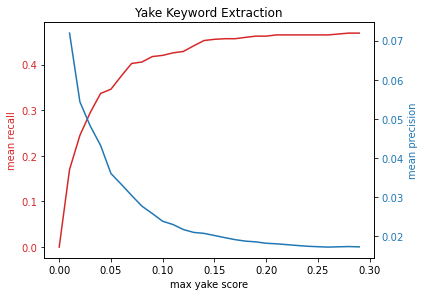

In [332]:
import numpy as np
import matplotlib.pyplot as plt

# Create some mock data
t = yake_output_dict['max_yake_score']
data1 = yake_output_dict['mean_recall']
data2 = yake_output_dict['mean_precision']

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('max yake score')
ax1.set_ylabel('mean recall', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('mean precision', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Yake Keyword Extraction')
plt.show()


## Rake

In [349]:
import nltk
from rake_nltk import Rake
nltk.download('stopwords')

def rakeExtractor(text):
    rake_nltk_var = Rake(max_length=3)
    rake_nltk_var.extract_keywords_from_text(text)
    keywords = rake_nltk_var.get_ranked_phrases_with_scores()[:500]
    return keywords


sections_df['rake_list_all'] = sections_df['text'].apply(lambda x: rakeExtractor(x))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [356]:
def selectRake(keywords, limit):
    rake_list = [i[1] for i in keywords if i[0] >= limit]
    return rake_list

rake_output_dict = {'max_rake_score':[], 'mean_rake_precision': [], 'mean_rake_recall':[]}

for i in np.arange(1, 12, 0.1):
    sections_df['rake_list'] = sections_df['rake_list_all'].apply(lambda x: selectRake(x, i))
    chapters_df['rake_keywords'] = chapters_df['chapter'].apply(lambda row: keywordCombiner(row, 'rake_list'))
    chapters_df['rake_precision'] = chapters_df.apply(lambda row: compareToListPrecision(row['rake_keywords'], row['textbook_keywords']), axis=1)
    chapters_df['rake_recall'] = chapters_df.apply(lambda row: compareToList(row['rake_keywords'], row['textbook_keywords']), axis=1)
    
    rake_output_dict['max_rake_score'].append(i)
    rake_output_dict['mean_rake_precision'].append(chapters_df['rake_precision'].mean())
    rake_output_dict['mean_rake_recall'].append(chapters_df['rake_recall'].mean())


In [354]:
pd.DataFrame.from_dict(rake_output_dict)

,max_rake_score,mean_rake_precision,mean_rake_recall
0,1.0,0.000869,0.012569
1,1.1,0.000847,0.012569
2,1.2,0.000800,0.012569
3,1.3,0.000838,0.014553
4,1.4,0.001257,0.019183
...,...,...,...
105,11.5,0.004387,0.565559
106,11.6,0.004387,0.565559
107,11.7,0.004387,0.565559
108,11.8,0.004387,0.565559


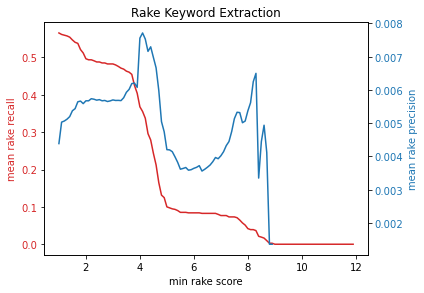

In [358]:
import numpy as np
import matplotlib.pyplot as plt

# Create some mock data
t = rake_output_dict['max_rake_score']
data1 = rake_output_dict['mean_rake_recall']
data2 = rake_output_dict['mean_rake_precision']

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('min rake score')
ax1.set_ylabel('mean rake recall', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('mean rake precision', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Rake Keyword Extraction')
plt.show()


## Log Likelihood

In [359]:
import datasets
from pathlib import Path

WIKI_CORPUS = Path().home() /'long_term_storage' / 'wikipedia_2022_03_01_en'
ds = datasets.load_from_disk(WIKI_CORPUS, keep_in_memory=False)

In [ ]:
wiki_fdist = {}
for text in ds['train']['text']:
    text_fdist = nltk.FreqDist([w.lower() for w in nltk.word_tokenize(text)])
    for i in text_fdist:
        if i.isalpha():
            if i in wiki_fdist.keys():
                wiki_fdist[i] += text_fdist[i]
            else: 
                wiki_fdist[i] = text_fdist[i]

In [ ]:
import json
with open('../data/wiki_fdist.txt', 'w') as convert_file:
     convert_file.write(json.dumps(wiki_fdist))

In [139]:
from nltk.tokenize import word_tokenize
nltk.download('brown')
from nltk.corpus import brown
import math

reference_text = brown.words()
ref_fdist = nltk.FreqDist([w.lower() for w in reference_text])

log_words = {}
for section in chapter_urls:
    text = getText(chapter_urls[section])
    text_fdist = nltk.FreqDist(word_tokenize(text.lower()))
    keyness_dict_draft = keyness(text_fdist,ref_fdist)
    keyness_dict = {}
    for key in keyness_dict_draft.keys():
        if key.isalpha():
            keyness_dict[key] = keyness_dict_draft[key]
    log_words[section] = sorted(keyness_dict, key=keyness_dict.get, reverse=True)[:20]

[nltk_data] Downloading package brown to /home/jovyan/nltk_data...
[nltk_data]   Package brown is already up-to-date!


## Output

In [140]:
def sectionToChapters(section_dict):
    chapter_keywords = {}
    for i in range(21):
        chapter = twoDig(i+1)
        word_list = []
        for section in section_dict:
            if section[:2] == chapter:
                word_list += section_dict[section]
        chapter_keywords[chapter] = word_list
    return chapter_keywords

yake_chapters = sectionToChapters(yake_words)
rake_chapters = sectionToChapters(rake_words)
log_chapters = sectionToChapters(log_words)

In [141]:
output_dict = {'chapter':[], 'num_key_terms':[]}
for chapter in keywords_dict:
    output_dict['chapter'].append(chapter)
    output_dict['num_sections'].append()
    output_dict['num_key_terms'].append(len(keywords_dict[chapter]))

yake_output = []
for chapter in output_dict['chapter']:
    yake_output.append(compareToList(yake_chapters[chapter], keywords_dict[chapter]))

rake_output = []
for chapter in output_dict['chapter']:
    rake_output.append(compareToList(rake_chapters[chapter], keywords_dict[chapter]))

log_output = []
for chapter in output_dict['chapter']:
    log_output.append(compareToList(log_chapters[chapter], keywords_dict[chapter]))
    
output_dict['yake_recall'] = yake_output
output_dict['rake_recall'] = rake_output
output_dict['log_recall'] = log_output

pd.DataFrame.from_dict(output_dict)

,chapter,num_key_terms,yake_recall,rake_recall,log_recall
0,01,24,0.458333,0.000000,0.125000
1,02,15,0.133333,0.000000,0.000000
2,03,36,0.472222,0.055556,0.083333
3,04,3,0.666667,0.000000,0.000000
4,05,18,0.333333,0.055556,0.055556
5,06,26,0.153846,0.038462,0.076923
6,07,18,0.444444,0.000000,0.111111
7,08,14,0.214286,0.000000,0.071429
8,09,17,0.235294,0.000000,0.235294
9,10,7,0.428571,0.000000,0.000000


In [203]:
def yakeListGetter(cutoff, section):
    text = getText(chapter_urls[section])
    kw_extractor = yake.KeywordExtractor()
    language = "en"
    max_ngram_size = 3
    deduplication_threshold = 0.9
    numOfKeywords = 100
    custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)
    keywords = custom_kw_extractor.extract_keywords(text)
    yake_df = pd.DataFrame(keywords)
    return list(yake_df[yake_df[1] < cutoff][0])


In [ ]:
from matplotlib import pyplot as plt

x = []
y = []
for i in np.arange(0,0.2, 0.01):
    yake_dict = {}
    chapter1_sections = ['01-1', '01-2', '01-3', '01-4']
    for section in chapter1_sections:
        yake_dict[section] = yakeListGetter(i, section)
    x.append(i)
    y.append(compareToList(sectionToChapters(yake_dict)['01'], keywords_dict['01']))

plt.plot(x, y)
plt.show()